In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from typing import Tuple, Dict

import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from jaxley_mech.channels.hh import Na, K, Leak, Na8States, K5States

import jaxley as jx
from jaxley import Compartment


In [2]:
# stimulus

# Duration and step size.
dt = 0.05  # ms

i_delay = 5.0  # ms
i_dur = 25.0  # ms
i_offset = .0
t_max = 50
current = jx.step_current(i_delay, i_dur, 0.002, dt, t_max, i_offset=i_offset)[:-1]

time_vec = jnp.arange(0, t_max, dt)


In [9]:
# original HH model
cell_hh = Compartment()

na_hh = Na(name="Na")
na_hh.channel_states = na_hh.init_state(v=-65, params=na_hh.channel_params)
k_hh = K(name="K")
k_hh.channel_states = k_hh.init_state(v=-65, params=k_hh.channel_params)
leak = Leak()

cell_hh.insert(na_hh)
cell_hh.insert(k_hh)
cell_hh.insert(leak)

params = {
    "Na_gNa": 120e-3,  # S/cm^2
    "Na_eNa": 47,  # mV

    "K_gK": 36e-3,  # S/cm^2
    "K_eK": -77,  # mV

    "Leak_gLeak": 0.3e-3,  # S/cm^2
    "Leak_eLeak": -54.3,  # mV

    "length": 5,
    "radius": 2.5,
    "v": -65.0,
}

for channel_name, channel_param in params.items():
    cell_hh.set(channel_name, channel_param)

cell_hh.stimulate(current)

for state_names in ["Na_m", "Na_h", "K_n", "Na_current", "K_current", "Leak_current", "v"]:
    cell_hh.record(state_names)

# run the model
s_hh = jx.integrate(cell_hh, delta_t=dt)


# markov formulation of HH model
cell_mm = Compartment()

na_mm = Na8States(name="Na")
na_mm.channel_states = na_mm.init_state(dt=dt, v=-65, params=na_mm.channel_params)
k_mm = K5States(name="K")
k_mm.channel_states = k_mm.init_state(dt=dt, v=-65, params=k_mm.channel_params)
leak = Leak()

cell_mm.insert(na_mm)
cell_mm.insert(k_mm)
cell_mm.insert(leak)

for channel_name, channel_param in params.items():
    cell_mm.set(channel_name, channel_param)

cell_mm.stimulate(current)

for state_names in ["Na_O", "K_O", "Na_current", "K_current", "Leak_current", "v"]:
    cell_mm.record(state_names)

# run the model
s_mm = jx.integrate(cell_mm, delta_t=dt)

gNa_mm = na_mm.channel_params["Na_gNa"] * s_mm[0].T[:-1] * 1000
gK_mm = k_mm.channel_params["K_gK"] * s_mm[1].T[:-1] * 1000


Text(0.5, 1.02, 'Hodgkin-Huxley model vs. Markov States model')

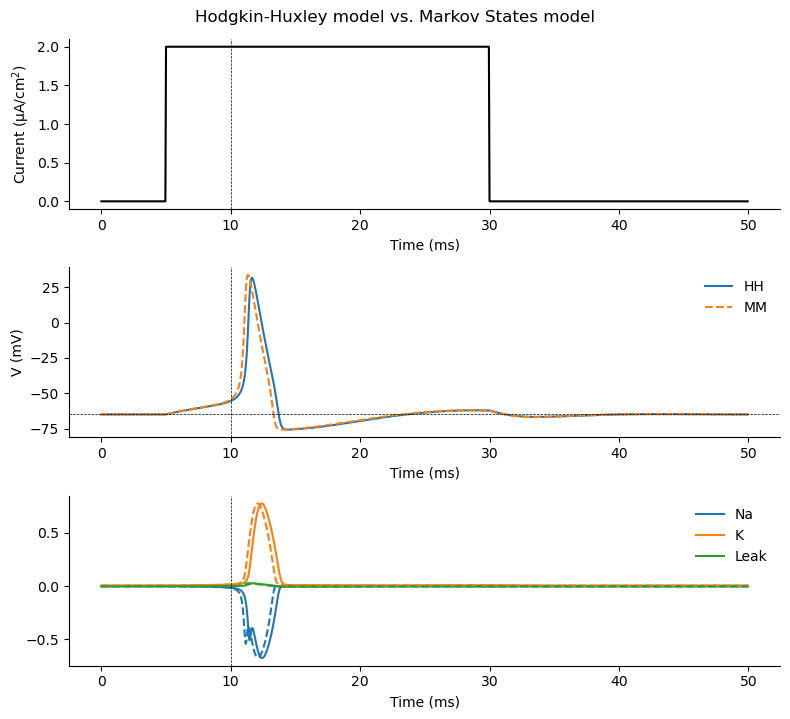

In [20]:
# compare the two models
fig, ax = plt.subplot_mosaic(
    mosaic=[["I"], ["V"], ["i"]], 
    figsize=(8, 7)
)

ax["I"].plot(time_vec, current * 1000, color='black')
ax["I"].set_ylabel("Current (nA/cm$^2$)")

ax["V"].plot(time_vec, s_hh[6].T[:-1], label="HH")
ax["V"].plot(time_vec, s_mm[5].T[:-1], label="MM", linestyle='--')
ax["V"].axhline(-65, color="black", lw=0.5, ls="--")
ax["V"].set_ylabel("V (mV)")
ax["V"].legend(frameon=False)

for i in range(3):
    ax["i"].plot(time_vec, s_hh[i+3].T[:-1] / 1000, color=f"C{i}") # g
ax["i"].legend(["Na", "K", "Leak"], frameon=False)    

for i in range(3):    
    ax["i"].plot(time_vec, s_mm[i+2].T[:-1] / 1000, color=f"C{i}", linestyle='--') # g

for a in ax.values():
    a.spines[["top", "right"]].set_visible(False)
    a.axvline(10, color="black", lw=0.5, ls="--")
    a.set_xlabel("Time (ms)")

fig.tight_layout()
fig.suptitle("Hodgkin-Huxley model vs. Markov States model", y=1.02)